<a href="https://colab.research.google.com/github/tokien1998/Company_Recommendation_System/blob/master/Capstone_Project_To_Trong_Kien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Company Peer Discovery using Autoencoder

Autoencoders are a neural network used for dimensionality reduction. The neural network learn the latent features of the dataset to transform input features into a compressed representation. 

It can be used for encoding high dimensionality data to reduce noise and compute the similarity between high dimensionality data points.

In this case, we have a list of compnay with their profiles. The problem statement is to find the peer of these companies. 

Traditionally, we would engage an expert and define ruleset to filter and sort these companies into specific buckets which is rather subjective. It would be prohibitive if the list is long, we have 12,491 companies in this list.

We can use autoencoders to encode companies into their latent vector and programmatically search for their peers objectively. Hence, machine learning enabled the discovery of peer companies in a scalable manner.

In this project, you will use an autoencoder to encode company profiles and create a machine learning system for peer discovery. You will go through the applied data science journey:

Data wrangling >> Machine Learning model training >> Serving machine learning model >> evaluating the effectiveness of the machine learning system.

Data file can be downloaded at:
https://drive.google.com/file/d/1FrqsCW758NbZgfKbEoCMDDLmf7kUPf2j/view?usp=sharing



## Adding GPU

We can add a GPU by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==2.0.0

# Data Cleaning and Encoding

In [2]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version: 2.0.0
Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.f to data.f
User uploaded file "data.f" with length 2068848 bytes


## Read data into dataframe and do some simple cleaning


In [0]:
import pandas as pd
import numpy as np

In [7]:
data_path = 'data.f'
raw_df = pd.read_feather(data_path)
raw_df.head(3)

,index,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Name,OS,Organization type,Region,Sector,Size,year
0,42434,Italy,OECD,No,No,Listed,Acea,None,Private company,Europe,Energy Utilities,Large,"2017,2016,2015,2014,2013,2012,2011,2010,2009,2..."
1,36391,United States of America,OECD,No,No,Listed,Bristol-Myers Squibb Company,None,Private company,Northern America,Healthcare Products,Large,"2016,2016,2014,2012,2011,2010,2009,2008,2007,2..."
2,29899,United Kingdom of Great Britain and Northern I...,OECD,No,None,Non-listed,British Airways,No,Subsidiary,Europe,Aviation,Large,"2015,2014,2013,2000,1999"


In [0]:
#df preprocessing
ncols_raw = len(raw_df.columns)

#drop duplicate index
raw_df.drop(raw_df.columns[0], axis=1, inplace=True)
raw_df.drop(labels=['year', 'Name', 'OS'], axis=1, inplace=True)
raw_df.replace(to_replace=[None], value=np.nan, inplace=True)

In [9]:
raw_df.head(3)

,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Organization type,Region,Sector,Size
0,Italy,OECD,No,No,Listed,Private company,Europe,Energy Utilities,Large
1,United States of America,OECD,No,No,Listed,Private company,Northern America,Healthcare Products,Large
2,United Kingdom of Great Britain and Northern I...,OECD,No,NaN,Non-listed,Subsidiary,Europe,Aviation,Large


In [10]:
#find columns that has na
raw_df.columns[raw_df.isna().any()]

Index(['Featured Report?', 'GOLD Community', 'Listed/Non-listed',
       'Organization type', 'Size'],
      dtype='object')

In [11]:
raw_df.describe()

,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Organization type,Region,Sector,Size
count,12491,12491,9802,9114,11833,11730,12491,12491,12458
unique,130,6,2,2,3,7,6,39,3
top,Mainland China,OECD,No,No,Listed,Private company,Asia,Financial Services,Large
freq,1337,6392,9788,8897,7018,8423,4488,1481,7468


In [0]:
#fill na with majorituy category
raw_df.fillna({'Featured Report?':'No', \
               'GOLD Community': 'No', \
               'Listed/Non-listed': 'Listed', \
               'OS':'No', \
               'Organization type': 'Private Company', 
               'Size': 'Large'}, inplace=True)

In [13]:
n_countries = raw_df[raw_df.columns[0]].unique().size
print("Total number of countries: {}".format(n_countries))

Total number of countries: 130


In [0]:
data_clean = raw_df.loc[:, 'Country Status':'Size'].copy()
countries = raw_df.loc[:, 'Country'].unique()

## Encode data

In [0]:
#Creates feature tokens for each feature (Hot-One-Encoding)
features_dataframe = data_clean.copy()
for feature in data_clean.columns:
      dfDummies = pd.get_dummies(data_clean[feature], prefix = feature)
      features_dataframe = pd.concat([features_dataframe, dfDummies], axis=1)

In [16]:
features_dataframe.head(3)

,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Organization type,Region,Sector,Size,Country Status_DAC-LDC,Country Status_DAC-LMICT,Country Status_DAC-OLIC,Country Status_DAC-UMICT,Country Status_Non-OECD / Non-DAC,Country Status_OECD,Featured Report?_No,Featured Report?_Yes,GOLD Community_No,GOLD Community_Yes,Listed/Non-listed_Listed,Listed/Non-listed_Non-listed,Listed/Non-listed_Not applicable,Organization type_Cooperative,Organization type_Non-profit organization,Organization type_Partnership,Organization type_Private Company,Organization type_Private company,Organization type_Public institution,Organization type_State-owned company,Organization type_Subsidiary,Region_Africa,Region_Asia,Region_Europe,Region_Latin America & the Caribbean,Region_Northern America,Region_Oceania,Sector_=,Sector_Agriculture,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
0,OECD,No,No,Listed,Private company,Europe,Energy Utilities,Large,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,OECD,No,No,Listed,Private company,Northern America,Healthcare Products,Large,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,OECD,No,No,Non-listed,Subsidiary,Europe,Aviation,Large,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
ncolumns_data = len(data_clean.columns) 
ncolumns_code = len(features_dataframe.columns) - ncolumns_data

print("Original data columns: {}".format(ncolumns_data))
print("Encoding columns: {}".format(ncolumns_code))

Original data columns: 8
Encoding columns: 69


In [0]:
# Removes encoding from the list of variables, the operation 
code_columns = list(features_dataframe.columns)[ncolumns_data:]

In [0]:
# Takes only the columns which have been one-hot-encoded
training_df = features_dataframe[code_columns].copy() 

In [20]:
training_df.head(2)

,Country Status_DAC-LDC,Country Status_DAC-LMICT,Country Status_DAC-OLIC,Country Status_DAC-UMICT,Country Status_Non-OECD / Non-DAC,Country Status_OECD,Featured Report?_No,Featured Report?_Yes,GOLD Community_No,GOLD Community_Yes,Listed/Non-listed_Listed,Listed/Non-listed_Non-listed,Listed/Non-listed_Not applicable,Organization type_Cooperative,Organization type_Non-profit organization,Organization type_Partnership,Organization type_Private Company,Organization type_Private company,Organization type_Public institution,Organization type_State-owned company,Organization type_Subsidiary,Region_Africa,Region_Asia,Region_Europe,Region_Latin America & the Caribbean,Region_Northern America,Region_Oceania,Sector_=,Sector_Agriculture,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
#Save File 
training_df.to_csv("encoded_data.csv")

# TF Dataset definition

In [0]:
import numpy as np
import tensorflow as tf
import os

np.random.seed(1)
tf.random.set_seed(1)

In [0]:
batch_size = 128

In [0]:
train_array = training_df.to_numpy(dtype=np.float32,copy=True)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_array)

In [0]:
train_dataset = train_dataset.batch(batch_size=batch_size)

In [0]:
train_dataset = train_dataset.shuffle(train_array.shape[0])

In [0]:
train_dataset = train_dataset.prefetch(batch_size*4)

# Model Definition

## Encoder

In [0]:
intermediate_dim = 23
original_dim = 69

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Encoder, self).__init__()
    hidden_dim_1 = int((original_dim + intermediate_dim)/2)
    self.hidden_layer_1 = tf.keras.layers.Dense(
      units=hidden_dim_1,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.hidden_layer_2 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.sigmoid
    )
    
  def call(self, input_features):
    activation = self.hidden_layer_1(input_features)
    activation = self.hidden_layer_2(activation)
    return self.output_layer(activation)

## Decoder

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, intermediate_dim, original_dim):
    super(Decoder, self).__init__()
    hidden_dim_2 = int((original_dim + intermediate_dim)/2)
    self.hidden_layer_1 = tf.keras.layers.Dense(
      units=intermediate_dim,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.hidden_layer_2 = tf.keras.layers.Dense(
      units=hidden_dim_2,
      activation=tf.nn.relu,
      kernel_initializer='he_uniform'
    )
    self.output_layer = tf.keras.layers.Dense(
      units=original_dim,
      activation=tf.nn.sigmoid
    )
  
  def call(self, code):
    activation = self.hidden_layer_1(code)
    activation = self.hidden_layer_2(activation)
    return self.output_layer(activation)

## Autoencoder

In [0]:
class Autoencoder(tf.keras.Model):
  def __init__(self, intermediate_dim, original_dim):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(
        intermediate_dim=intermediate_dim, 
        original_dim=original_dim
    )
    self.decoder = Decoder(
        intermediate_dim=intermediate_dim,
        original_dim=original_dim
    )
  
  def call(self, input_features):
    code = self.encoder(input_features)
    reconstructed = self.decoder(code)
    return reconstructed

# Model and Training Setup

In [0]:
autoencoder = Autoencoder(
  intermediate_dim=intermediate_dim,
  original_dim=original_dim
)

In [0]:
learning_rate = 0.5e-2
opt = tf.optimizers.Adam(learning_rate=learning_rate)

In [0]:
def loss(model, original):
  reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
  return reconstruction_error
  
def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, original), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

# Training

In [0]:
epochs = 50
save_path = "drive/My Drive/model_checkpoints"

In [0]:
def make_folder(path):
  try:
    os.mkdir(path)
  except FileExistsError:
    print("Directory already exist.")
  return

In [0]:
make_folder(save_path)

In [39]:
save_freq = 5
writer = tf.summary.create_file_writer('{}/tmp'.format(save_path))
sample_loss = [] # for comparing the new autoencoder model
with writer.as_default():
  with tf.summary.record_if(True):
    for epoch in range(epochs):
        for step, batch_features in enumerate(train_dataset):
            train(loss, autoencoder, opt, batch_features)
            loss_values = loss(autoencoder, batch_features)
            original = batch_features
            reconstructed = autoencoder(tf.constant(batch_features))
            tf.summary.scalar('loss', loss_values, step=step)
            tf.summary.write('original', original, step=step)
            tf.summary.write('reconstructed', reconstructed, step=step)

        sample_loss.append(loss_values)

        if epoch%save_freq == 0:
            tf.print("Epoch: {}".format(epoch))
            tf.print(" . Loss:", loss_values)
            path = "{}/epoch_{:03d}".format(save_path, epoch)
            make_folder(path)
            autoencoder.save_weights(path)


Epoch: 0
 . Loss: 0.0375696234
Epoch: 5
 . Loss: 0.0161242168
Epoch: 10
 . Loss: 0.0147565119
Epoch: 15
 . Loss: 0.012879014
Epoch: 20
 . Loss: 0.00997560937
Epoch: 25
 . Loss: 0.00992559083
Epoch: 30
 . Loss: 0.0153965158
Epoch: 35
 . Loss: 0.0134125408
Epoch: 40
 . Loss: 0.0120112
Epoch: 45
 . Loss: 0.0146431252


# Capstone Project Statement

## Instructions:
1. Create a copy of this collab notebook and suffix it with your name
2. Run through the code example above
3. Work on the project objectives below inside the copy of the notebook

## 1. Use the autoencoder as a basis to create a machine learning model to find the Top 5 similar company given an target company. 

Note: Implement an API/function to query for Top 5 similar company given an target company. Assuming the target company is within the data.f file.

### Prepare datasets

In [40]:
# duplicate raw dataframe and fast cleanning
dup_raw_df = pd.read_feather(data_path)
dup_raw_df.replace(to_replace=[None], value=np.nan, inplace=True)

# Find columns that has na
dup_raw_df.columns[dup_raw_df.isna().any()]

Index(['Featured Report?', 'GOLD Community', 'Listed/Non-listed', 'OS',
       'Organization type', 'Size'],
      dtype='object')

In [41]:
dup_raw_df.iloc[:,1:].describe()

,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Name,OS,Organization type,Region,Sector,Size,year
count,12491,12491,9802,9114,11833,12491,688,11730,12491,12491,12458,12491
unique,130,6,2,2,3,12491,2,7,6,39,3,1541
top,Mainland China,OECD,No,No,Listed,MA 48,No,Private company,Asia,Financial Services,Large,2017
freq,1337,6392,9788,8897,7018,1,675,8423,4488,1481,7468,795


In [0]:
# Fill na
dup_raw_df.fillna({'Featured Report?':'No', \
                    'GOLD Community': 'No', \
                    'Listed/Non-listed': 'Listed', \
                    'OS':'No', \
                    'Organization type': 'Private Company', 
                    'Size': 'Large'}, inplace=True)

In [43]:
# duplicate raw dataframes for two excercises
ex1_raw_df = dup_raw_df.copy()
ex2_raw_df = dup_raw_df.copy()

# preview
ex1_raw_df.head(3)

,index,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Name,OS,Organization type,Region,Sector,Size,year
0,42434,Italy,OECD,No,No,Listed,Acea,No,Private company,Europe,Energy Utilities,Large,"2017,2016,2015,2014,2013,2012,2011,2010,2009,2..."
1,36391,United States of America,OECD,No,No,Listed,Bristol-Myers Squibb Company,No,Private company,Northern America,Healthcare Products,Large,"2016,2016,2014,2012,2011,2010,2009,2008,2007,2..."
2,29899,United Kingdom of Great Britain and Northern I...,OECD,No,No,Non-listed,British Airways,No,Subsidiary,Europe,Aviation,Large,"2015,2014,2013,2000,1999"


### Get information of a specific company

In [44]:
#@title Preview the name of X companies
start_index =  20#@param {type:"number"}
end_index = 25#@param {type:"number"}

# Preview the name of companies
if ((start_index >= 0 and start_index <= len(ex1_raw_df)) and (end_index >= 0 and end_index <= len(ex1_raw_df))):
    if (end_index - start_index) > 0:
        print('Number of previewed companies: ', (end_index - start_index))
        print('The name list:')
        for item in list(ex1_raw_df['Name'].copy().unique()[start_index:end_index]):
            print(' . ', item)
    else:
        print('Please re-enter the index value!')
else:
    raise NameError('Please enter index value between 0 and {}!'.format(len(ex1_raw_df)))
    

Number of previewed companies:  5
The name list:
 .  Eskom
 .  Ford Motor Company
 .  Fuji Xerox
 .  FUJIFILM Holdings Corporation
 .  Genencor


In [0]:
#@title Paste the company name here
company_name = "FUJIFILM Holdings Corporation" #@param {type:"string"}

In [46]:
if(company_name in ex1_raw_df['Name'].values):
    print('The Company "' + company_name + '" is founded!')
else:
    raise NameError('This company name is not founded in "data.f" dataset!')

The Company "FUJIFILM Holdings Corporation" is founded!


In [0]:
# df preprocessing
target_company_df = ex1_raw_df[ex1_raw_df.Name == company_name].copy()
other_companies_df = ex1_raw_df[ex1_raw_df.Name != company_name].copy()

### Get the target vector of given company

In [0]:
def df_preprocessing(dataframe, exercise):
    if(exercise == 'Exercise 1'):
        # drop columns
        dataframe.drop(labels=['index', 'year', 'Name', 'OS'], axis=1, inplace=True)
        dataframe.replace(to_replace=[None], value=np.nan, inplace=True)

        # find columns that has na
        dataframe.columns[dataframe.isna().any()]

        #fill na with majorituy category
        dataframe.fillna({'Featured Report?':'No', \
                    'GOLD Community': 'No', \
                    'Listed/Non-listed': 'Listed', \
                    'OS':'No', \
                    'Organization type': 'Private Company', 
                    'Size': 'Large'}, inplace=True)
        
        dataframe_clean = dataframe.loc[:, 'Country Status':'Size'].copy()

    elif(exercise == 'Exercise 2'):
        # drop columns
        dataframe.drop(labels=['index', 'Name', 'year'], axis=1, inplace=True)
        dataframe.replace(to_replace=[None], value=np.nan, inplace=True)

        # find columns that has na
        dataframe.columns[dataframe.isna().any()]

        #fill na with majorituy category
        dataframe.fillna({'Featured Report?':'No', \
                    'GOLD Community': 'No', \
                    'Listed/Non-listed': 'Listed', \
                    'OS':'No', \
                    'Organization type': 'Private Company', 
                    'Size': 'Large'}, inplace=True)
        
        dataframe_clean = dataframe.copy()

    else:
        print('Unknown Exercise...')

    dataframe_ori_cols = dataframe_clean.shape[1] # Number of cleaned original columns
    return dataframe_clean, dataframe_ori_cols

In [0]:
# Create a function to get one-hot code dataframe
def get_code_df(dataframe, get_type, exercise):
    dataframe_clean, dataframe_ori_cols = df_preprocessing(dataframe, exercise)

    if(exercise == 'Exercise 1'):
        if(get_type == 'filter'):
            _features_df = features_dataframe.copy()

            # create a dictionary of origin values of the target company 
            target_com_dict = dataframe_clean.to_dict(orient='records')[0]

            # show a data list with satisfying conditions
            for key, value in target_com_dict.items():
                _features_df = _features_df[_features_df[key] == value].copy()
                target_features_df = _features_df

            # drop duplicates
            target_features_df = target_features_df.drop_duplicates()

            # Takes only the columns which have been one-hot-encoded
            target_vector = target_features_df[target_features_df.columns[dataframe_ori_cols:]]
            return dataframe_clean, dataframe_clean.head(3), target_vector, target_vector.head(3)
            
        if(get_type == 'one-hot'):
            # One-hot-encoding
            token_dataframe = dataframe_clean.copy()
            for feature in dataframe_clean.columns:
                dfDummies = pd.get_dummies(dataframe_clean[feature], prefix = feature)
                token_dataframe = pd.concat([token_dataframe, dfDummies], axis=1)

            # Get the full dataframe for the last step
            full_df = token_dataframe.copy()

            # Take only the columns which have been one-hot-encoded
            token_df = token_dataframe[token_dataframe.columns[dataframe_ori_cols:]]
            return dataframe_clean, dataframe_clean.head(3), token_df, token_df.head(3), full_df
    
    elif(exercise == 'Exercise 2'):
        if(get_type == 'filter'):
            ori_df = df_preprocessing(ex2_raw_df.copy(), exercise='Exercise 2')[0]

            # One-hot-encoding
            ori_dataframe = ori_df.copy()
            for feature in ori_df.columns:
                dfDummies = pd.get_dummies(ori_df[feature], prefix = feature)
                ori_dataframe = pd.concat([ori_dataframe, dfDummies], axis=1)

            _features_df = ori_dataframe

            # create a dictionary of origin values of the target company 
            target_com_dict = dataframe_clean.to_dict(orient='records')[0]

            # show a data list with satisfying conditions
            for key, value in target_com_dict.items():
                _features_df = _features_df[_features_df[key] == value].copy()
                target_features_df = _features_df

            # drop duplicates
            target_features_df = target_features_df.drop_duplicates()

            # Takes only the columns which have been one-hot-encoded
            target_vector = target_features_df[target_features_df.columns[dataframe_ori_cols:]]
            return dataframe_clean, dataframe_clean.head(3), target_vector, target_vector.head(3)

        elif(get_type == 'one-hot'):
            # One-hot-encoding
            token_dataframe = dataframe_clean.copy()
            for feature in dataframe_clean.columns:
                dfDummies = pd.get_dummies(dataframe_clean[feature], prefix = feature)
                token_dataframe = pd.concat([token_dataframe, dfDummies], axis=1)

            # Get the full dataframe for the last step
            full_df = token_dataframe.copy()

            # Take only the columns which have been one-hot-encoded
            token_df = token_dataframe[token_dataframe.columns[dataframe_ori_cols:]]
            return dataframe_clean, dataframe_clean.head(3), token_df, token_df.head(3), full_df


In [50]:
# preview target company
target_company, prv_target_company, encoded_target_company, prv_encoded_target_company = get_code_df(target_company_df.copy(), get_type='filter', exercise='Exercise 1')
display(prv_target_company, prv_encoded_target_company, encoded_target_company.shape)

,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Organization type,Region,Sector,Size
23,OECD,No,No,Listed,Private company,Asia,Conglomerates,Large


,Country Status_DAC-LDC,Country Status_DAC-LMICT,Country Status_DAC-OLIC,Country Status_DAC-UMICT,Country Status_Non-OECD / Non-DAC,Country Status_OECD,Featured Report?_No,Featured Report?_Yes,GOLD Community_No,GOLD Community_Yes,Listed/Non-listed_Listed,Listed/Non-listed_Non-listed,Listed/Non-listed_Not applicable,Organization type_Cooperative,Organization type_Non-profit organization,Organization type_Partnership,Organization type_Private Company,Organization type_Private company,Organization type_Public institution,Organization type_State-owned company,Organization type_Subsidiary,Region_Africa,Region_Asia,Region_Europe,Region_Latin America & the Caribbean,Region_Northern America,Region_Oceania,Sector_=,Sector_Agriculture,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
23,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


(1, 69)

In [51]:
# preview other companies
other_companies, prv_other_companies, encoded_other_companies, prv_encoded_other_companies, df_for_last_step = get_code_df(other_companies_df.copy(), get_type='one-hot', exercise='Exercise 1')
display(prv_other_companies, prv_encoded_other_companies, encoded_other_companies.shape)

,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Organization type,Region,Sector,Size
0,OECD,No,No,Listed,Private company,Europe,Energy Utilities,Large
1,OECD,No,No,Listed,Private company,Northern America,Healthcare Products,Large
2,OECD,No,No,Non-listed,Subsidiary,Europe,Aviation,Large


,Country Status_DAC-LDC,Country Status_DAC-LMICT,Country Status_DAC-OLIC,Country Status_DAC-UMICT,Country Status_Non-OECD / Non-DAC,Country Status_OECD,Featured Report?_No,Featured Report?_Yes,GOLD Community_No,GOLD Community_Yes,Listed/Non-listed_Listed,Listed/Non-listed_Non-listed,Listed/Non-listed_Not applicable,Organization type_Cooperative,Organization type_Non-profit organization,Organization type_Partnership,Organization type_Private Company,Organization type_Private company,Organization type_Public institution,Organization type_State-owned company,Organization type_Subsidiary,Region_Africa,Region_Asia,Region_Europe,Region_Latin America & the Caribbean,Region_Northern America,Region_Oceania,Sector_=,Sector_Agriculture,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


(12490, 69)

In [52]:
target_vector_69 = encoded_target_company.to_numpy(dtype=np.float32, copy=True)
target_vector_69.shape

(1, 69)

In [53]:
other_vectors_69 = encoded_other_companies.to_numpy(dtype=np.float32, copy=True)
other_vectors_69.shape

(12490, 69)

### Dimension Reduction by Encoder

In [0]:
encoder = Encoder(
    intermediate_dim=intermediate_dim,
    original_dim=original_dim
)

decoder = Decoder(
    intermediate_dim=intermediate_dim,
    original_dim=original_dim
)

In [55]:
# list of 23-dimensions vectors

# encode target vector
target_vector_23 = encoder(target_vector_69)
target_vector_23.shape

TensorShape([1, 23])

In [56]:
# encode other vectors
other_vectors_23 = encoder(other_vectors_69)
other_vectors_23.shape

TensorShape([12490, 23])

### Calculate the distance between the target vector and other vectors in dataset

In [0]:
def vector_loss(vector_1, vector_2):
    distance_value = np.linalg.norm(vector_1 - vector_2)
    return distance_value

In [58]:
loss_index_dict = {}

for index, vector in enumerate(other_vectors_23):
    loss_value = vector_loss(vector_1=target_vector_23, vector_2=vector)
    loss_index_dict.update({loss_value : index})

    if index%1000 == 0:
        print('Step:', index)
        print(' . Distance: {}'.format(loss_value))

Step: 0
 . Distance: 0.2706526815891266
Step: 1000
 . Distance: 0.2629547417163849
Step: 2000
 . Distance: 0.26175427436828613
Step: 3000
 . Distance: 0.17016035318374634
Step: 4000
 . Distance: 0.24755623936653137
Step: 5000
 . Distance: 0.29576238989830017
Step: 6000
 . Distance: 0.33508485555648804
Step: 7000
 . Distance: 0.23701833188533783
Step: 8000
 . Distance: 0.5927746295928955
Step: 9000
 . Distance: 0.39439743757247925
Step: 10000
 . Distance: 0.17016035318374634
Step: 11000
 . Distance: 0.22466495633125305
Step: 12000
 . Distance: 0.31637024879455566


### Choose 5 minimum distances (top 5 similar companies)

In [59]:
top5_min_dist_idx = sorted(loss_index_dict.items(), key= lambda item: item[0])[:5]
print('Top 5 minimum distances with specific steps (distance-step):')
for item in top5_min_dist_idx:
    print(' . {item}'.format(item=item))

Top 5 minimum distances with specific steps (distance-step):
 . (9.424322e-08, 10629)
 . (0.09044244, 6014)
 . (0.096435755, 9278)
 . (0.101429224, 10006)
 . (0.10160583, 4729)


### Define the index of each vector in the origin dataframe

In [60]:
# Index value of target vector (given company) in the origin dataframe
target_index = target_company.index.values.astype(int)[0]
print('Index value of target vector (given company):', target_index)

Index value of target vector (given company): 23


In [61]:
# Index value of top 5 minimum-distance vector (similar companies) in the origin dataframe
top5_indexes = []
for step in top5_min_dist_idx:
    if step[1] >= target_index:
        top5_indexes.append(step[1] + 1)
    else:
        top5_indexes.append(step[1])

top5_indexes = sorted(top5_indexes)
print('Top 5 similar companies sort by index:')
for index in top5_indexes:
    print(' . ', index)

Top 5 similar companies sort by index:
 .  4730
 .  6015
 .  9279
 .  10007
 .  10630


### Find the information of Top 5

In [62]:
given_company = ex1_raw_df.loc[[target_index],:]
print('The given company:')
given_company

The given company:


,index,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Name,OS,Organization type,Region,Sector,Size,year
23,44805,Japan,OECD,No,No,Listed,FUJIFILM Holdings Corporation,No,Private company,Asia,Conglomerates,Large,"2017,2016,2015,2014,2013,2012,2011,2010,2009,2..."


In [63]:
# seleceted features (sf)
top5_similar_companies_sf = features_dataframe.iloc[top5_indexes,:ncolumns_data]
print('Top 5 similar companies (selected features):')
top5_similar_companies_sf

Top 5 similar companies (selected features):


,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Organization type,Region,Sector,Size
4730,OECD,No,No,Listed,Subsidiary,Asia,Construction,Large
6015,OECD,No,No,Listed,Private company,Asia,Healthcare Services,Large
9279,OECD,No,No,Listed,Private company,Asia,Food and Beverage Products,Large
10007,Non-OECD / Non-DAC,No,No,Listed,State-owned company,Asia,Public Agency,Large
10630,OECD,No,No,Listed,Private company,Asia,Conglomerates,Large


In [64]:
# full features (ff)
top5_similar_companies_ff = ex1_raw_df.loc[top5_indexes,:]
print('Top 5 similar companies (full features):')
top5_similar_companies_ff

Top 5 similar companies (full features):


,index,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,Name,OS,Organization type,Region,Sector,Size,year
4730,48115,Japan,OECD,No,No,Listed,Takasago Thermal Engineering,No,Subsidiary,Asia,Construction,Large,"2017,2016,2015,2014,2013,2012,2011"
6015,40915,Japan,OECD,No,No,Listed,Shionogi,No,Private company,Asia,Healthcare Services,Large,"2016,2015,2014,2013,2012"
9279,40031,Israel,OECD,No,No,Listed,Osem Group,No,Private company,Asia,Food and Beverage Products,Large,"2016,2015"
10007,37352,United Arab Emirates,Non-OECD / Non-DAC,No,No,Listed,Dubai Police General Headquarters,No,State-owned company,Asia,Public Agency,Large,2016
10630,47762,"Korea, Republic of",OECD,No,No,Listed,SK Holdings,No,Private company,Asia,Conglomerates,Large,"2017,2016"


## 2. Improve on the company encoder by using more features or use a different architecture to improve performance of the Top 5 similar company API.

### Get new datasets of the given company and the rest

In [65]:
# preview target company
target_company_2, prv_target_company_2, encoded_target_company_2, prv_encoded_target_company_2 = get_code_df(target_company_df.copy(), get_type='filter', exercise='Exercise 2')
display(prv_target_company_2, prv_encoded_target_company_2, encoded_target_company_2.shape)

,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,OS,Organization type,Region,Sector,Size
23,Japan,OECD,No,No,Listed,No,Private company,Asia,Conglomerates,Large


,Country_Albania,Country_Andorra,Country_Angola,Country_Argentina,Country_Australia,Country_Austria,Country_Bahrain,Country_Bangladesh,Country_Belarus,Country_Belgium,Country_Bermuda,Country_Bolivia,Country_Botswana,Country_Brazil,Country_Bulgaria,Country_Burkina Faso,Country_Burundi,Country_Cambodia,Country_Cameroon,Country_Canada,Country_Cape Verde,Country_Cayman Islands,Country_Channel Islands,Country_Chile,Country_Colombia,Country_Costa Rica,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Côte d'Ivoire,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_El Salvador,Country_Estonia,Country_Ethiopia,Country_Finland,Country_France,Country_Gabon,...,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


(1, 201)

In [66]:
# preview other companies
other_companies_2, prv_other_companies_2, encoded_other_companies_2, prv_encoded_other_companies_2, df_for_last_step_2 = get_code_df(other_companies_df.copy(), get_type='one-hot', exercise='Exercise 2')
display(prv_other_companies_2, prv_encoded_other_companies_2, encoded_other_companies_2.shape)

,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,OS,Organization type,Region,Sector,Size
0,Italy,OECD,No,No,Listed,No,Private company,Europe,Energy Utilities,Large
1,United States of America,OECD,No,No,Listed,No,Private company,Northern America,Healthcare Products,Large
2,United Kingdom of Great Britain and Northern I...,OECD,No,No,Non-listed,No,Subsidiary,Europe,Aviation,Large


,Country_Albania,Country_Andorra,Country_Angola,Country_Argentina,Country_Australia,Country_Austria,Country_Bahrain,Country_Bangladesh,Country_Belarus,Country_Belgium,Country_Bermuda,Country_Bolivia,Country_Botswana,Country_Brazil,Country_Bulgaria,Country_Burkina Faso,Country_Burundi,Country_Cambodia,Country_Cameroon,Country_Canada,Country_Cape Verde,Country_Cayman Islands,Country_Channel Islands,Country_Chile,Country_Colombia,Country_Costa Rica,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Côte d'Ivoire,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_El Salvador,Country_Estonia,Country_Ethiopia,Country_Finland,Country_France,Country_Gabon,...,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


(12490, 201)

In [67]:
# full dataset
ex2_full_ori_df, prv_ex2_full_ori_df, ex2_token_full_df, prv_ex2_token_full_df, ex2_full_df = get_code_df(ex2_raw_df.copy(), get_type='one-hot', exercise='Exercise 2')
display(prv_ex2_full_ori_df, prv_ex2_token_full_df, ex2_token_full_df.shape)

,Country,Country Status,Featured Report?,GOLD Community,Listed/Non-listed,OS,Organization type,Region,Sector,Size
0,Italy,OECD,No,No,Listed,No,Private company,Europe,Energy Utilities,Large
1,United States of America,OECD,No,No,Listed,No,Private company,Northern America,Healthcare Products,Large
2,United Kingdom of Great Britain and Northern I...,OECD,No,No,Non-listed,No,Subsidiary,Europe,Aviation,Large


,Country_Albania,Country_Andorra,Country_Angola,Country_Argentina,Country_Australia,Country_Austria,Country_Bahrain,Country_Bangladesh,Country_Belarus,Country_Belgium,Country_Bermuda,Country_Bolivia,Country_Botswana,Country_Brazil,Country_Bulgaria,Country_Burkina Faso,Country_Burundi,Country_Cambodia,Country_Cameroon,Country_Canada,Country_Cape Verde,Country_Cayman Islands,Country_Channel Islands,Country_Chile,Country_Colombia,Country_Costa Rica,Country_Croatia,Country_Cyprus,Country_Czech Republic,Country_Côte d'Ivoire,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_El Salvador,Country_Estonia,Country_Ethiopia,Country_Finland,Country_France,Country_Gabon,...,Sector_Automotive,Sector_Aviation,Sector_Chemicals,Sector_Commercial Services,Sector_Computers,Sector_Conglomerates,Sector_Construction,Sector_Construction Materials,Sector_Consumer Durables,Sector_Energy,Sector_Energy Utilities,Sector_Equipment,Sector_Financial Services,Sector_Food and Beverage Products,Sector_Forest and Paper Products,Sector_Healthcare Products,Sector_Healthcare Services,Sector_Household and Personal Products,Sector_Logistics,Sector_Media,Sector_Metals Products,Sector_Mining,Sector_Non-Profit / Services,Sector_Other,Sector_Public Agency,Sector_Railroad,Sector_Real Estate,Sector_Retailers,Sector_Technology Hardware,Sector_Telecommunications,Sector_Textiles and Apparel,Sector_Tobacco,Sector_Tourism/Leisure,Sector_Toys,Sector_Universities,Sector_Waste Management,Sector_Water Utilities,Size_Large,Size_MNE,Size_SME
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


(12491, 201)

In [68]:
ncolumns_data_2 = ex2_full_ori_df.shape[1]
ncolumns_code_2 = ex2_token_full_df.shape[1]
full_columns_2 = ex2_full_df.shape[1]

print("Original data columns: {}".format(ncolumns_data_2))
print("Encoding columns: {}".format(ncolumns_code_2))
print("Total columns: {}".format(full_columns_2))

Original data columns: 10
Encoding columns: 201
Total columns: 211


### TensorFlow Dataset Definition

In [0]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(1)
tf.random.set_seed(1)

In [0]:
training_df2 = ex2_token_full_df.copy()

In [0]:
train_array_2 = training_df2.to_numpy(dtype=np.float32,copy=True)

In [0]:
train_dataset_2 = tf.data.Dataset.from_tensor_slices(train_array_2)

### New Model Definition

In [0]:
intermediate_dim_ = 49
original_dim_ = 201

step = (original_dim_ - intermediate_dim_)/4

hidden_dim1 = original_dim_ - step      #163
hidden_dim2 = original_dim_ - 2*step    #125
hidden_dim3 = original_dim_ - 3*step    #87

#### Model structure

In [0]:
# Input Layer
input_layer = Input(shape=(original_dim_,))

# Hidden layers
hidden_layer_input_batch = BatchNormalization()(input_layer)
hidden_layer_1_ = Dense(hidden_dim1, activation='relu', kernel_initializer='he_uniform')(hidden_layer_input_batch)
hidden_layer_1_batch = BatchNormalization()(hidden_layer_1_)
hidden_layer_2_ = Dense(hidden_dim2, activation='relu', kernel_initializer='he_uniform')(hidden_layer_1_batch)
hidden_layer_2_batch = BatchNormalization()(hidden_layer_2_)
hidden_layer_3_ = Dense(hidden_dim3, activation='relu', kernel_initializer='he_uniform')(hidden_layer_2_batch)
hidden_layer_3_batch = BatchNormalization()(hidden_layer_3_)
intermediate_layer_ = Dense(intermediate_dim_, activation='relu', kernel_initializer='he_uniform')(hidden_layer_3_batch)
intermediate_layer_batch = BatchNormalization()(intermediate_layer_)
hidden_layer_4_ = Dense(hidden_dim3, activation='relu', kernel_initializer='he_uniform')(intermediate_layer_batch)
hidden_layer_4_batch = BatchNormalization()(hidden_layer_4_)
hidden_layer_5_ = Dense(hidden_dim2, activation='relu', kernel_initializer='he_uniform')(hidden_layer_4_batch)
hidden_layer_5_batch = BatchNormalization()(hidden_layer_5_)
hidden_layer_6_ = Dense(hidden_dim1, activation='relu', kernel_initializer='he_uniform')(hidden_layer_5_batch)
hidden_layer_6_batch = BatchNormalization()(hidden_layer_6_)

# Output Layer
output_layer = Dense(original_dim_, activation='sigmoid')(hidden_layer_6_batch)

#### New Autoencoder

In [75]:
# New Autoencoder model
n_autoencoder = Model(input_layer, output_layer)

# Model Summary
n_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 201)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 201)               804       
_________________________________________________________________
dense_12 (Dense)             (None, 163)               32926     
_________________________________________________________________
batch_normalization_1 (Batch (None, 163)               652       
_________________________________________________________________
dense_13 (Dense)             (None, 125)               20500     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125)               500       
_________________________________________________________________
dense_14 (Dense)             (None, 87)                10962 

#### New Encoder

In [76]:
# New Encoder model
n_encoder = Model(input_layer, intermediate_layer_batch)

# Model Summary
n_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 201)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 201)               804       
_________________________________________________________________
dense_12 (Dense)             (None, 163)               32926     
_________________________________________________________________
batch_normalization_1 (Batch (None, 163)               652       
_________________________________________________________________
dense_13 (Dense)             (None, 125)               20500     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125)               500       
_________________________________________________________________
dense_14 (Dense)             (None, 87)                1096

#### New Decoder

In [77]:
# create a placeholder for an encoded (49-dimensional) input
decoded_input = Input(shape=(intermediate_dim_,))

# Retrieve layers of the new autoencoder model
decoded_hidden = n_autoencoder.layers[-8](decoded_input)
decoded_hidden = n_autoencoder.layers[-7](decoded_hidden)
decoded_hidden = n_autoencoder.layers[-6](decoded_hidden)
decoded_hidden = n_autoencoder.layers[-5](decoded_hidden)
decoded_hidden = n_autoencoder.layers[-4](decoded_hidden)
decoded_hidden = n_autoencoder.layers[-3](decoded_hidden)
decoded_hidden = n_autoencoder.layers[-2](decoded_hidden)

decoded_output = n_autoencoder.layers[-1](decoded_hidden)

# New Decoder model
n_decoder = Model(decoded_input, decoded_output)

# Model Summary
n_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 49)                196       
_________________________________________________________________
dense_16 (Dense)             (None, 87)                4350      
_________________________________________________________________
batch_normalization_5 (Batch (None, 87)                348       
_________________________________________________________________
dense_17 (Dense)             (None, 125)               11000     
_________________________________________________________________
batch_normalization_6 (Batch (None, 125)               500       
_________________________________________________________________
dense_18 (Dense)             (None, 163)               2053

### Model & Training Setup

In [0]:
new_save_path = "drive/My Drive/new_model_checkpoints"
make_folder(new_save_path)
checkpoint_path = "new_model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

In [0]:
n_autoencoder.compile(optimizer=opt, loss=losses.mean_squared_error)

In [80]:
n_autoencoder_train = n_autoencoder.fit(
    x= train_array_2,
    y= train_array_2,
    epochs= epoch + 1,
    batch_size= batch_size*8,
    callbacks= [cp_callback] # Pass callback to training
)                               

Train on 12491 samples
Epoch 1/50
10240/12491 [=======================>......] - ETA: 0s - loss: 0.1277
Epoch 00001: saving model to new_model_checkpoints/cp.ckpt
12491/12491 [==============================] - 3s 204us/sample - loss: 0.1116
Epoch 2/50
12288/12491 [============================>.] - ETA: 0s - loss: 0.0326
Epoch 00002: saving model to new_model_checkpoints/cp.ckpt
12491/12491 [==============================] - 0s 14us/sample - loss: 0.0332
Epoch 3/50
12288/12491 [============================>.] - ETA: 0s - loss: 0.0281
Epoch 00003: saving model to new_model_checkpoints/cp.ckpt
12491/12491 [==============================] - 0s 14us/sample - loss: 0.0280
Epoch 4/50
 7168/12491 [================>.............] - ETA: 0s - loss: 0.0205
Epoch 00004: saving model to new_model_checkpoints/cp.ckpt
12491/12491 [==============================] - 0s 14us/sample - loss: 0.0199
Epoch 5/50
 7168/12491 [================>.............] - ETA: 0s - loss: 0.0173
Epoch 00005: saving model t

### Evaluate new model

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

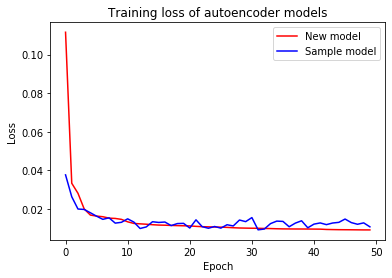

In [82]:
loss = n_autoencoder_train.history['loss']
epoch_range = range(epoch + 1)
plt.figure()
plt.plot(epoch_range, loss, label='New model', color='red')
plt.plot(epoch_range, sample_loss, label='Sample model', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss of autoencoder models')
plt.legend()
plt.show()

### Save the final model

In [83]:
final_patch = "drive/My Drive/final_model"
make_folder(final_patch)

n_autoencoder.save(final_patch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/My Drive/final_model/assets
